In [1]:
# Diversity

from scipy.stats import entropy
import math
from datautil import *

def cal_entropy(values):
    mig_num = len(values)
    add_libs = set(values['add_lib'].values)
    p = []
    for add_lib in add_libs:
        num = len(values[values['add_lib']==add_lib])
        p.append(num * 1.0 / mig_num)
    e = entropy(p, base=2)
    return pd.DataFrame([{
        'rem_lib': values['rem_lib'].values[0],
        'domain': values['domain'].values[0],
        'entropy': e,
        'rule_num': len(values['add_lib'].value_counts()),
        'mig_num': mig_num,
    }])


c_e_df = preprocess(get_mig("c")).groupby('rem_lib', as_index=False).apply(cal_entropy).reset_index().drop(columns=['level_0', 'level_1'])
python_e_df = get_mig("python").groupby('rem_lib', as_index=False).apply(cal_entropy).reset_index().drop(columns=['level_0', 'level_1'])
java_e_df = get_mig("java").groupby('rem_lib', as_index=False).apply(cal_entropy).reset_index().drop(columns=['level_0', 'level_1'])
js_e_df = get_mig("js").groupby('rem_lib', as_index=False).apply(cal_entropy).reset_index().drop(columns=['level_0', 'level_1'])

e_df = {
    'C/C++': c_e_df,
    'Python': python_e_df,
    'Java': java_e_df,
    'JavaScript': js_e_df,
}

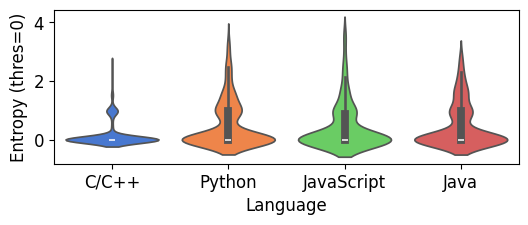

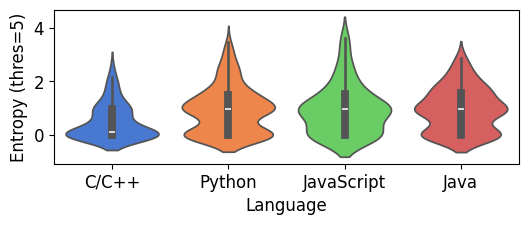

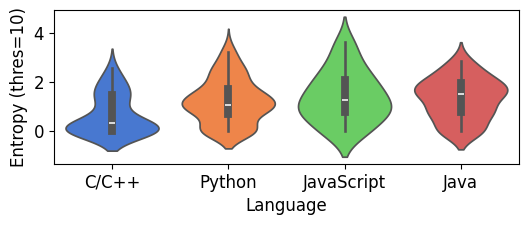

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['font.size'] = 12

for language, df in e_df.items():
    df['language'] = language

data = pd.concat([c_e_df, python_e_df, js_e_df, java_e_df])
 

def draw_violin(data, label, THRES):
    fig, axes=plt.subplots(figsize=(6,2))
    data = data[(data['mig_num'] > THRES)]  # only consider the source libraries with migrations > THRES
    bplot1 = sns.violinplot(x='language', y=label, data=data, width=0.8, inner='box', palette='muted', saturation=1)
    axes.set_xlabel("Language")
    axes.set_ylabel(label.title() + f" (thres={THRES})")
    if THRES == 0:
        fig.savefig(f"fig/{label}_violin.pdf",
                        bbox_inches="tight")

draw_violin(data, 'entropy', 0)  # the paper only shows fig when THRES = 0, i.e., all source libraries
draw_violin(data, 'entropy', 5)  # source libraries with migrations > 10
draw_violin(data, 'entropy', 10)  # source libraries with migrations > 50

In [6]:
def filter(e_df, THRES_E, THRES_R):
    # THRES_E:  threshold for max entropy
    # THRES_R:  threshold for min migration rule
    if THRES_R > 0:  # libraries with rule >= THRES_R
        multi_total = len(e_df[(e_df["entropy"] > 0) & (e_df["rule_num"] >= THRES_R)])
        multi_lower = len(
            e_df[
                (e_df["entropy"] > 0)
                & (e_df["rule_num"] == THRES_R)
                & (e_df["entropy"] <= THRES_E)
            ]
        )
        return multi_lower, multi_total
    else:
        single_total = len(e_df)
        single_lower = len(e_df[(e_df["entropy"] <= THRES_E)])
        return single_lower, single_total


print("Entroy(l) = 0")
for language, df in e_df.items():
    lower, total = filter(df, 0, 0)
    print(f"  {language}: {lower} libraries ({lower/len(df) * 100:.2f}%)")
print("0 < Entropy(l) < 0.88")
for language, df in e_df.items():
    lower, total = filter(df, 0.88, 2)
    print(f"  {language}: {lower} libraries ({lower/total * 100:.2f}% of the libraries with entropy > 0)")
print("Entropy(l) > 0.97")
for language, df in e_df.items():
    lower, total = map(sum, zip(filter(df, 0.97, 2), filter(df, 1.57, 3)))
    print(f"  {language}: {total - lower} libraries ({lower/len(df) * 100:.2f}%)")

Entroy(l) = 0
  C/C++: 449 libraries (83.46%)
  Python: 202 libraries (63.32%)
  Java: 141 libraries (65.28%)
  JavaScript: 96 libraries (69.57%)
0 < Entropy(l) < 0.88
  C/C++: 15 libraries (16.85% of the libraries with entropy > 0)
  Python: 11 libraries (9.40% of the libraries with entropy > 0)
  Java: 11 libraries (14.67% of the libraries with entropy > 0)
  JavaScript: 6 libraries (14.29% of the libraries with entropy > 0)
Entropy(l) > 0.97
  C/C++: 64 libraries (8.36%)
  Python: 139 libraries (13.17%)
  Java: 85 libraries (12.50%)
  JavaScript: 46 libraries (10.87%)


In [10]:
# Directionality

import pandas as pd
import numpy as np

languages = ["c", "python", "js", "java"]
label = {
    "c": "C/C++",
    "python": "Python",
    "java": "Java",
    "js": "JavaScript",
}
def cal_flow(x):
    in_degree = x["in_num"]
    out_degree = x["out_num"]
    return np.abs(in_degree - out_degree) / (in_degree + out_degree)


def get_flow_by_language(df, language, THRES):  # # only consider the libraries with migrations > THRES
    # THRES: threshold for min migrations
    df_in = df["add_lib"].value_counts().reset_index()
    df_out = df["rem_lib"].value_counts().reset_index()
    df_in.columns = ["lib", "in_num"]
    df_out.columns = ["lib", "out_num"]
    df_inout = df_in.merge(df_out, on="lib", how="outer")
    df_inout = df_inout.fillna(0)
    df_inout["mig_num"] = df_inout["in_num"] + df_inout["out_num"]
    df_inout = df_inout[df_inout["mig_num"] > THRES]
    df_inout["flow"] = df_inout.apply(cal_flow, axis=1)
    df_inout = df_inout[df_inout['in_num'] + df_inout['out_num'] > 1]
    df_inout["language"] = language
    return df_inout


def get_flow(THRES):
    flow_dict = {}

    flow_data = pd.DataFrame()
    for l in languages:
        mig_df = get_mig(l)
        flow_df = get_flow_by_language(mig_df, label[l], THRES)
        flow_data = pd.concat([flow_data, flow_df])
    return flow_data

In [11]:
flow_data = get_flow(0)
print("Flow(l) = 1")
for language in languages:
    flow = flow_data[flow_data["language"]==label[language]]
    uni_num = len(flow[(flow["flow"] >= 1)])
    print(f"  {label[language]}: {uni_num} libraries ({uni_num/len(flow) * 100:.2f}%)")

Flow(l) = 1
  C/C++: 388 libraries (79.67%)
  Python: 360 libraries (71.43%)
  JavaScript: 210 libraries (84.68%)
  Java: 281 libraries (78.93%)


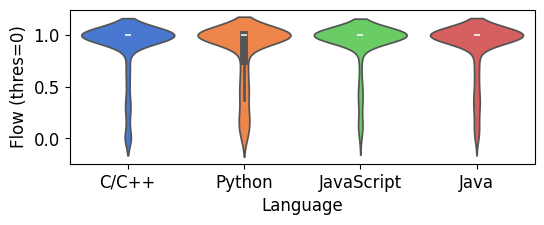

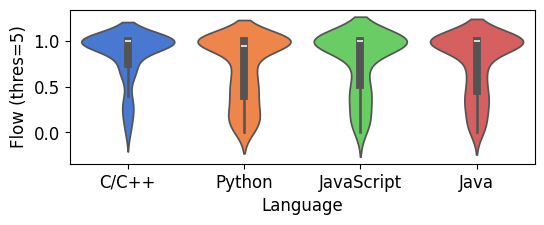

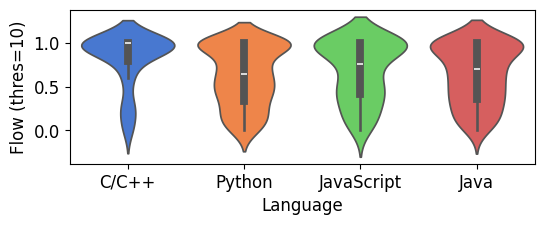

In [14]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

for THRES in [0, 5, 10]:    # only consider the libraries with migrations > THRES
    flow_data = get_flow(THRES)
    draw_violin(flow_data, "flow", THRES)  # the paper only show when thres = 0